<h1><center>Telecom Customer Churn Prediction</center>

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from matplotlib import colormaps
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score

In [2]:
# Ignore future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Load the data
df = pd.read_csv("data/Telco-Customer-Churn.csv")

In [4]:
# Show all columns in Pandas without truncating
pd.set_option('display.max_columns', None)

# Cleaning and Exploratory Data Analysis

In [5]:
# Show the data table
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# Print (rows, columns) for the data
df.shape

(7043, 21)

In [7]:
# Print the List of Columns
list(df.columns)

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [8]:
# Rename columns for consistency
df = df.rename(columns={"customerID": "CustomerID", "gender": "Gender", "tenure": "Tenure"})

## Unique values

In [9]:
# Print all unique values for each column
for col in df.columns:
    print(f"{col}:")
    print(df[col].unique())

CustomerID:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Gender:
['Female' 'Male']
SeniorCitizen:
[0 1]
Partner:
['Yes' 'No']
Dependents:
['No' 'Yes']
Tenure:
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService:
['No' 'Yes']
MultipleLines:
['No phone service' 'No' 'Yes']
InternetService:
['DSL' 'Fiber optic' 'No']
OnlineSecurity:
['No' 'Yes' 'No internet service']
OnlineBackup:
['Yes' 'No' 'No internet service']
DeviceProtection:
['No' 'Yes' 'No internet service']
TechSupport:
['No' 'Yes' 'No internet service']
StreamingTV:
['No' 'Yes' 'No internet service']
StreamingMovies:
['No' 'Yes' 'No internet service']
Contract:
['Month-to-month' 'One year' 'Two year']
PaperlessBilling:
['Yes' 'No']
PaymentMethod:
['Electronic check' 'Mailed check' 'Bank transfer (automatic)

Some of the features have possible values that are dependent on another feature. For example, Multiple Lines has 'No phone service' as a possible value. When it takes values of 'Yes' or 'No', it implies the user has phone service. 

When modeling, 'Phone Service' and 'Internet Service' woiuld have to be excluded in order to prevent issues with independence/autocorrelation. Considering how phone service and internet service could be determined from other columns, it would probably be better to remove those columns entirely.

## Data types

In [10]:
# Check data types for each column
df.dtypes

CustomerID           object
Gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
Tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Most of the data is in object type. This makes sense as most of the data is categorical. 

SeniorCitizen should be changed to an object or string because it is an identifier rather than a numerical value.

Total Charges is an object, while Monthly Charges is in float64. Total Charges should be changed to float64 since the values are supposed to be numeric.

In [11]:
# Convert LoyaltyID to an object
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

# Convert 'Total Charges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [12]:
# Verify that the data types were changed for 'LoyaltyID' and 'Total Charges'
df.dtypes

CustomerID           object
Gender               object
SeniorCitizen        object
Partner              object
Dependents           object
Tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Total Charges were successfully changed into the appropriate data types.

## Handle Missing Values

In [13]:
# Check for nulls
print('Number of Nulls:')
print(int(df.isna().sum().sum()))

Number of Nulls:
11


In [14]:
# Find all rows with missing values
df[df.isna().any(axis=1)]

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


There are only null values for the Total Charges column. Since there happens to be values for the Monthly Charges for each row, we can impute the missing values with the corresponding Monthly Charges. What happened was probably that the users are new and just had their first Monthly Charge. We will impute the missing values with the corresponding Monthly Charge.

In [15]:
# Impute nulls with Monthly Charges
df.loc[df['TotalCharges'].isna(), 'TotalCharges'] = df.loc[df['TotalCharges'].isna(), 'MonthlyCharges']

In [16]:
# Check for nulls
print('Number of Nulls:')
print(int(df.isna().sum().sum()))

Number of Nulls:
0


There are no rows with missing values in the data anymore. To further verify if the imputation was done correctly, let's find the rows that had their missing values imputed. 

We will use the Customer ID to filter the data.

In [17]:
# Check some of the previous rows with missing values
# df[df['CustomerID'].astype(str).isin(['4472-LVYGI', '3115-CZMZD', '5709-LVOEQ'])]
df[df['CustomerID'].isin(['4472-LVYGI', '3115-CZMZD', '5709-LVOEQ'])]

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,52.55,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,20.25,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,80.85,No


Here are some of the rows, and we can see that the Total Charges are now the same as the Monthly Charges for these users.

## Remove Any Extra White Space in the Data

In [18]:
# Select columns that are objects
cat_cols = df.select_dtypes(include=['object']).columns

# Remove any extra white space
df[cat_cols] = df[cat_cols].apply(lambda x: x.astype(str).str.strip())

## Check for Duplicate Rows

In [19]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


## Change values for the Senior Citizen column to No and Yes

In [20]:
# Add SeniorCitizen to transformed dataframe
df['SeniorCitizen'] = df['SeniorCitizen'].map({'0': 'No', '1': 'Yes'})

In [21]:
# Save the data to an excel file
df.to_excel('data/cleaned_telecom_customer_churn.xlsx', sheet_name='Telecom Data', index=False)

## Summary Statistics

In [22]:
# Summary Statistics
df.describe()

,Tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.798992
std,24.559481,30.090047,2266.730170
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


The Summary Statistics table is only printed for the 3 non-object columns. 

From the means, mins, and maxes, the values seem similar in magnitude have significant differences in magnitude between Total Charges and the other 2 features. 

Tenure, although hard to tell just looking at feature name, is in months. The value of 72 represents 6 years. Half of the company's customers have stayed with them for around 2 and a half years.

In [23]:
# Filter the data for Total Charges over $8500 and having 72 months of Tenure
df[(df['TotalCharges'] > 8500) & (df['Tenure'] == 72)]

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2368,6650-BWFRT,Female,No,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),117.15,8529.50,No
4586,7569-NMZYQ,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.75,8672.45,No
4610,2889-FPWRM,Male,No,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),117.80,8684.80,Yes
5347,9788-HNGUT,Male,No,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),116.95,8594.40,No
5558,0675-NCDYU,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),116.40,8543.25,No
6118,9924-JPRMC,Male,No,No,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.20,8547.15,No
6768,9739-JLPQJ,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),117.50,8670.10,No


In [24]:
8684/72

120.61111111111111

In [25]:
# Filter the data for Total Charges over $8500 and having months of Tenure other than 72
df[(df['TotalCharges'] > 8000) & (df['Tenure'] != 72)]

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
896,8975-SKGRX,Male,No,Yes,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.10,8310.55,No
1306,0201-OAMXR,Female,No,No,No,70,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),115.55,8127.60,Yes
1767,3669-WHAFY,Female,No,Yes,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),115.15,8078.10,No
2115,8984-HPEMB,Female,No,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.65,8477.60,No
2187,8879-XUAHX,Male,No,Yes,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,116.25,8564.75,No
2926,0106-UGRDO,Female,No,Yes,No,69,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,116.00,8182.85,No
3299,4282-MSACW,Male,No,No,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),117.20,8035.95,No
3878,2223-GDSHL,Male,No,Yes,Yes,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.05,8297.50,No
4562,5322-TEUJK,Female,No,Yes,Yes,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),114.60,8100.25,No
5113,9258-CNWAC,Female,No,Yes,Yes,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),113.65,8166.80,No


The range of values look reasonable for Total Charges.

In [26]:
# Filter the data for Monthly Charges over $120
df[(df['MonthlyCharges'] > 120)]

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


The range of values look reasonable for Monthly Charges as well. 

Considering how reasonable the values appear, we will consider the data free from outliers and refrain from further action in order to preserve data integrity.

## Correlation Heatmap

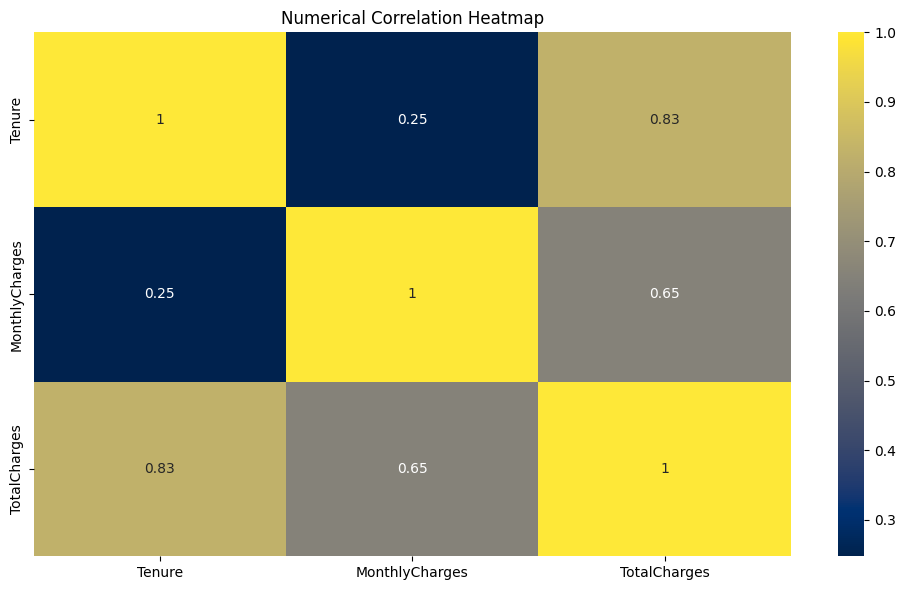

In [27]:
# Select columns that are not objects
num_cols = df.select_dtypes(exclude=['object']).columns

# Find the correlation matrix
corr = df[num_cols].corr()

# Construct the Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt='.2g', cmap='cividis')
plt.title('Numerical Correlation Heatmap')
plt.tight_layout()
plt.savefig('churn_prediction_visuals/numerical_heatmap')
plt.show()

- Tenure has high 0.83 positive correlation with Total Charges, which is reasonable considering the longer a customer stays with the company, the more money they will have paid.
- Monthly Charges has a moderate 0.65 positive correlation with Total Charges, indicating that a number of customers change their plans internally or get charged different monthly fees by getting add-ons while they are suscribed.
- These customers may have received promotional rates first but stayed after returning to normal charges, changed to another plan within the company's selection, or purchased add-ons or bundles.
- Monthly Charges has a weak 0.25 positive correlation with Tenure, signaling that customers may have switched to cheaper plans internally or incurred other expenses through additional add-on purchases or bundles.

## Plot Categorical Variable Counts

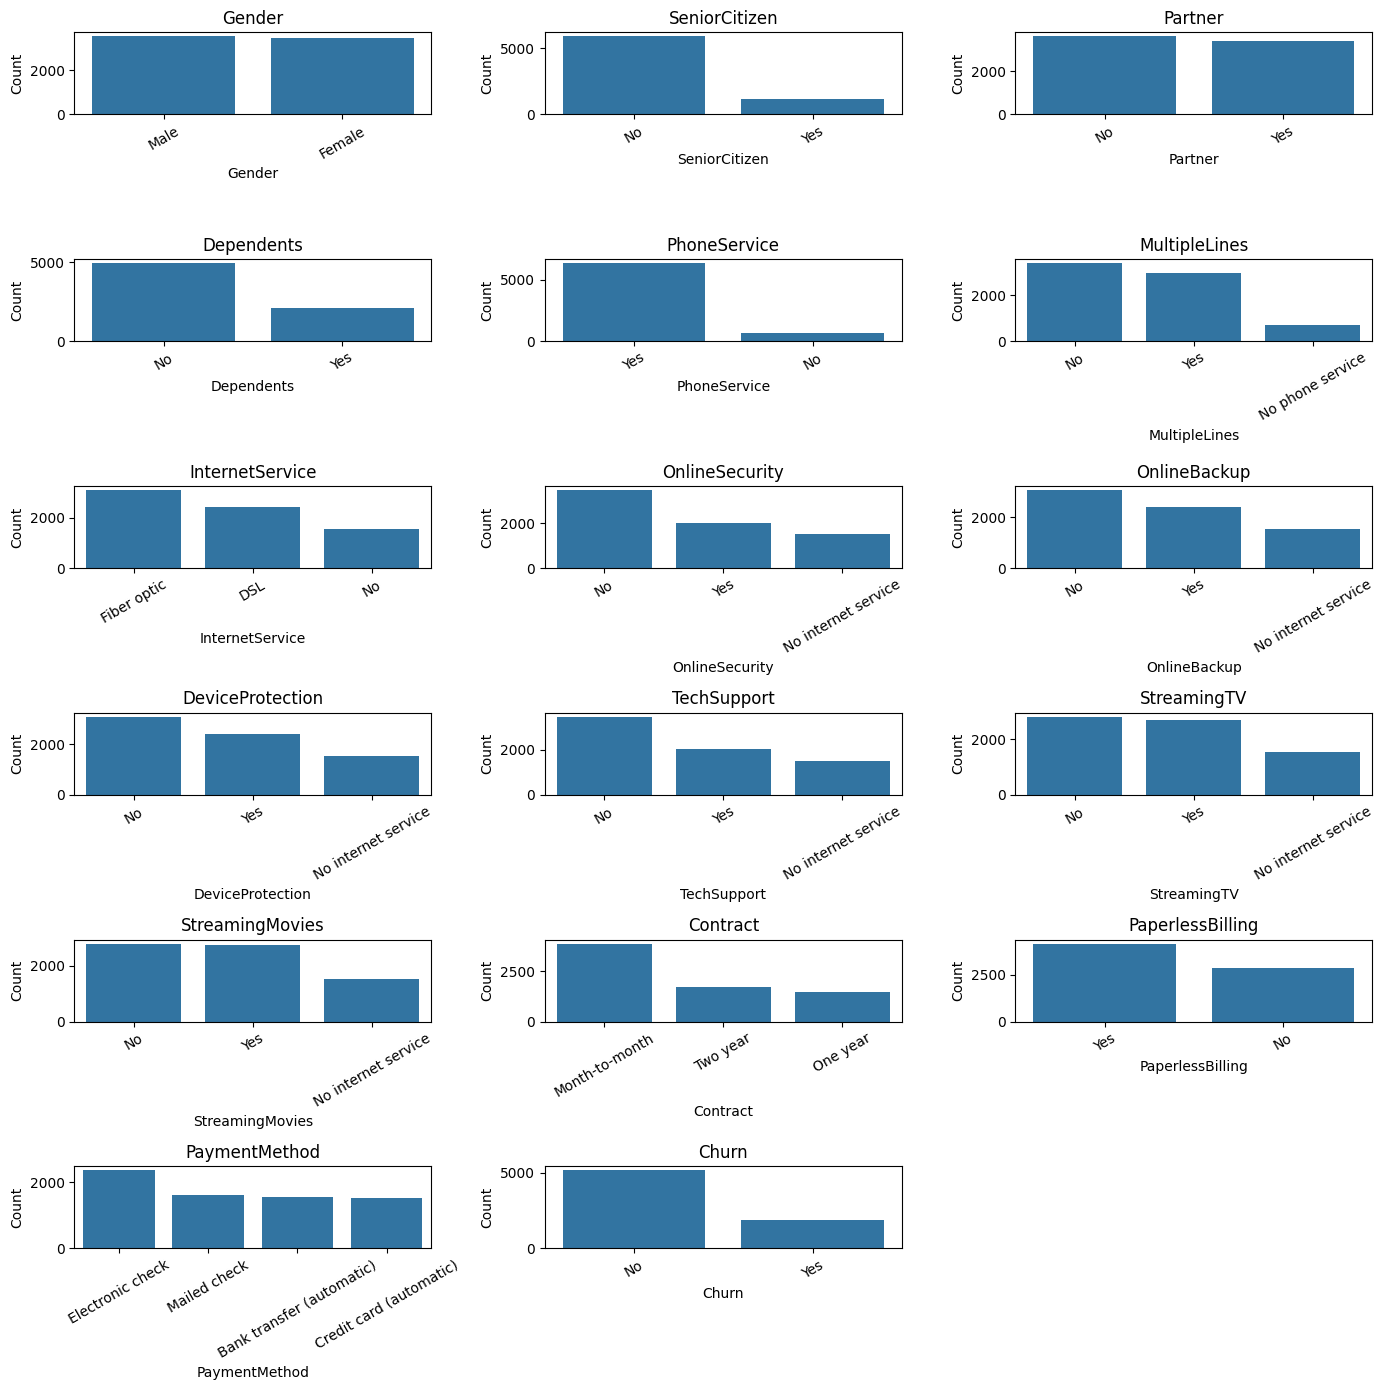

In [28]:
# Find Categorical Columns to plot
cat_cols_to_plot = [col for col in df.select_dtypes(include=['object']).columns 
                    if col not in ['CustomerID']]

# Set subplots
fig, axes = plt.subplots(6, 3, figsize=(14, 14))
axes = axes.flatten() 

# Make the bar plots
for i, column in enumerate(cat_cols_to_plot):
    sns.countplot(data=df, x=column, ax=axes[i], order=df[column].value_counts().index)
    axes[i].set_title(f"{column}")
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=30)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig('churn_prediction_visuals/categorical_var_counts')
plt.show()

From the plots of the counts for each feature, we see there is some imbalance for each feature except for Partner. Telecom data tends to have imbalanced data. 

For the time being, we will proceed without taking action to balance the data, as it may be better to have the model work with what may be naturally imbalanced data. If we forcefully balance it, that may introduce biases.

## Plot Distributions of Numerical Features

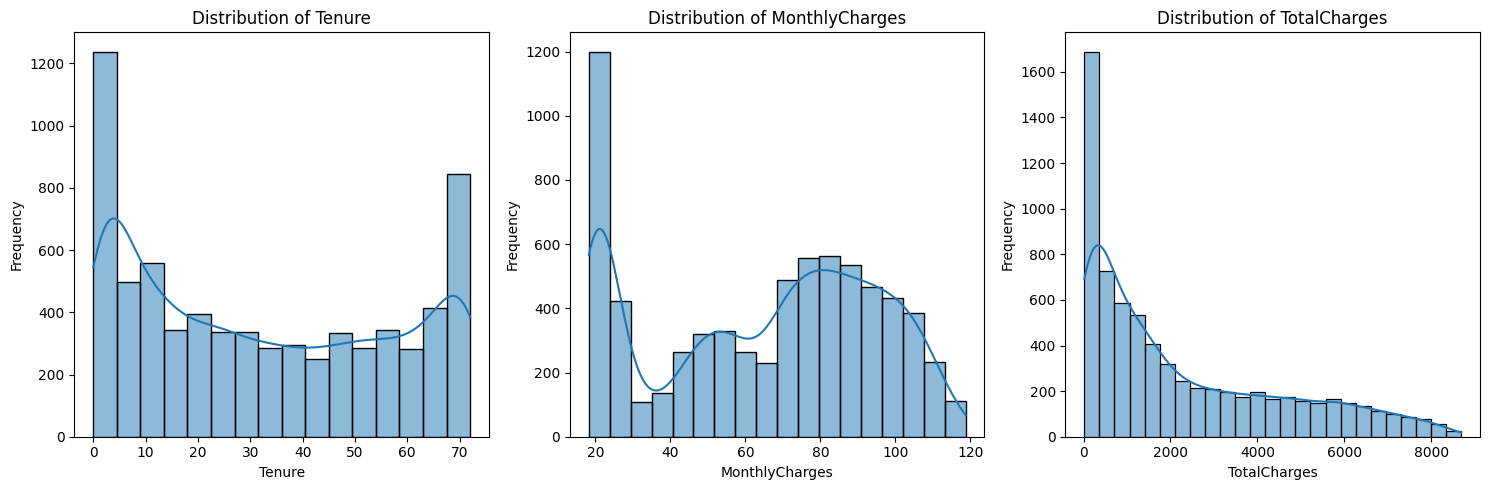

In [29]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('churn_prediction_visuals/numerical_distributions')
plt.show()

The features do not have normal distributions. Tenure and Monthly Charges are multimodal, while Total Charges is right skewed.

# Modeling

XGBoost will be used as the model to predict customer churn. XGBoost is a tree type model that trains first using a base learning, then computes the errors. It will then train to reduce those errors and compute new errors, repeating the process until a stopping condition is met. XGBoost can be used for both classification and regression tasks. For this project, churn prediction is a classification task. 

The evaluation metric best suited for the situation is aucpr. This is the area under the Precision - Recall Curve and it is chosen since the data is imbalanced and correctly predicting whether customers will churn is top priority. 

3 Models will be developed using different techniques.

## Transform Numerical Features

In [30]:
# Apply Yeo-Johnson transformation to numerical features
pt = PowerTransformer(method='yeo-johnson')
df_transformed = df.copy()
df_transformed[num_cols] = pt.fit_transform(df_transformed[num_cols])
df_transformed.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,-1.644343,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,-1.158541,-1.805206,No
1,5575-GNVDE,Male,No,No,No,0.297205,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,-0.239492,0.256861,No
2,3668-QPYBK,Male,No,No,No,-1.495444,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,-0.342665,-1.381338,Yes
3,7795-CFOCW,Male,No,No,No,0.646327,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),-0.731079,0.235865,No
4,9237-HQITU,Female,No,No,No,-1.495444,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0.213545,-1.244141,Yes


The data is transformed to take into account the skewed distribution. Since we will be using XGBoost for the model, the data will not need to be scaled. Also, Total Charges which is some high correlations to Monthly Charges and Tenure will be removed here as well.

In [31]:
# Drop the total Charges column
df_transformed = df_transformed.drop(columns='TotalCharges')

## Encode Categorical Features

In [32]:
# Find Binary Columns
binary_cols = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn']

# Encoding Binary Columns
for col in binary_cols:
    df_transformed[col] = df_transformed[col].map({'No': 0, 'Yes': 1})

# Encode Gender
df_transformed['Gender'] = df_transformed['Gender'].map({'Female': 0, 'Male': 1})

# Add SeniorCitizen to transformed dataframe
df_transformed['SeniorCitizen'] = df_transformed['SeniorCitizen'].map({'No': 0, 'Yes': 1})

# Set Additional Service Columns
add_service_cols = [
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# Encode Additional Service Columns
df_transformed = pd.get_dummies(df_transformed, columns=add_service_cols, drop_first=True, dtype=int)

# Set Contract and Payment Method
other_cols = ['Contract', 'PaymentMethod']

# Encode Contract and Payment Method
df_transformed = pd.get_dummies(df_transformed, columns=other_cols, drop_first=True, dtype=int)

# Save an encoded copy of the data
df_encoded = df_transformed.copy()

# Save the data to an excel file
df_encoded.to_excel('data/encoded_telecom_customer_churn.xlsx', sheet_name='Telecom Data', index=False)

In [33]:
# Print first 5 rows of data
df_transformed.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,InternetService,PaperlessBilling,MonthlyCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,-1.644343,No,DSL,1,-1.158541,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,0.297205,Yes,DSL,0,-0.239492,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,3668-QPYBK,1,0,0,0,-1.495444,Yes,DSL,1,-0.342665,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,7795-CFOCW,1,0,0,0,0.646327,No,DSL,0,-0.731079,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,-1.495444,Yes,Fiber optic,1,0.213545,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Check Unique Values for Each Feature

In [34]:
# Print all unique values for each column
for col in df_transformed.columns:
    print(f"{col}:")
    print(df_transformed[col].unique())

CustomerID:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Gender:
[0 1]
SeniorCitizen:
[0 1]
Partner:
[1 0]
Dependents:
[0 1]
Tenure:
[-1.6443435   0.29720527 -1.49544443  0.64632675 -0.92628704 -0.16269601
 -0.78871081  0.08053824  1.10445427 -0.60622285 -0.44435051  1.00352171
  0.76159927 -0.03718286  1.27288016  0.84473766  1.31927073 -0.2065339
 -0.66440415  0.15530631  0.70462831  1.34219847 -0.39396295  0.04208131
 -1.16936305  0.67564931 -0.72512119  1.29616592  1.12912864  0.58660355
 -0.49640807  1.05444632 -0.34510326  1.20189603 -0.8555903  -1.37221793
  0.19168912  0.78961168  1.15359039  0.95163168 -1.00148358  0.5561775
  0.33125677  0.7332748   0.11826746  1.17784456  0.43037665  1.2494094
  0.22744746  0.9253082   0.3978215   0.36478829  0.52535695 -1.08208957
 -1.26512968  0.26261052  1.22574947 -0.11990163  0.97770058  1.07956199
 -0.55030087 -0.25148998  0.8718688   0.4941272   1.02910155 -0.07808394
  0.61664894 -0.29764818  0

The categories were all encoded. Drop_first was used to remove the first category/dummary variable created to remove multicollinearity issues and prevent the dummy variable trap. 

For example, the device_protection feature took values of 'Yes', 'No', or 'No internet service'. 

The dummy variables in the dataframe are 'Yes' and 'No internet service'. The category of 'No' is implied from values of 0 in the 'Yes' dummy variable.

## Feature Selection

In [35]:
# Remove unneeded or highly dependent features
features = df_transformed.drop(columns=['CustomerID', 'PhoneService', 'InternetService'])

## Split the Data

In [36]:
# Set independent variables
X = features.drop(columns='Churn')

# Set dependent variable
y = features['Churn']

# Split the data at a 80:20 ratio and set the random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [37]:
features.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PaperlessBilling,MonthlyCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,-1.644343,1,-1.158541,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0.297205,0,-0.239492,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,-1.495444,1,-0.342665,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0.646327,0,-0.731079,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,-1.495444,1,0.213545,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Fit the Base Model

We will first fit an XGBoost model without setting or tuning hyperparameters to get a baseline for performance. The random state is set to 42 to get reproducible results. 

In [38]:
# Initialize the classifier
model = xgb.XGBClassifier(
    eval_metric='aucpr',
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Predict labels for the test set
y_pred = model.predict(X_test)

## Model Validation

### ROC-AUC

In [39]:
# AUC ROC score
y_pred_prob = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.8303642593186829


The ROC AUC score is high and means that the model is good at distinguishing between the 2 classes.

### Classification Report

In [40]:
# Classification report
print('Classification Report:\n')
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1036
           1       0.59      0.49      0.54       373

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



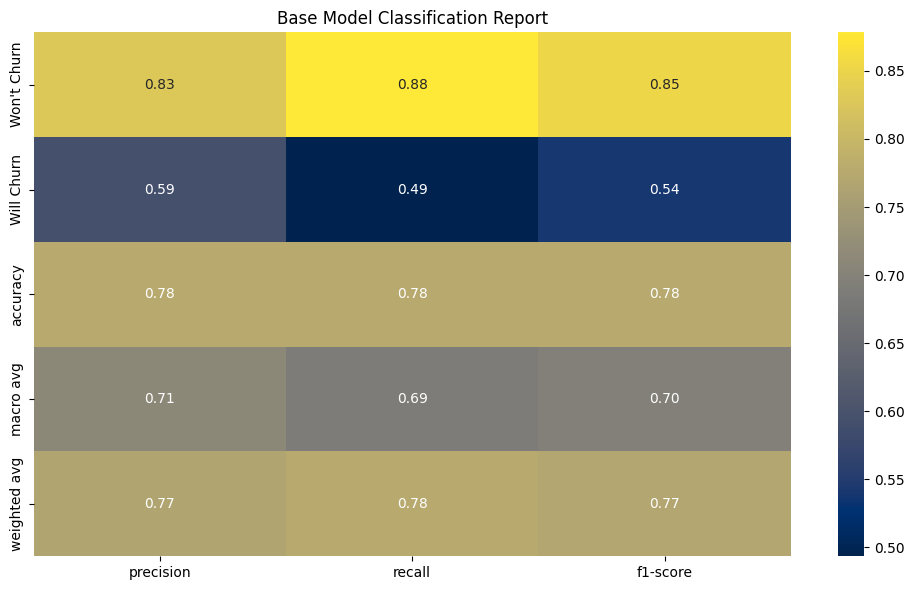

In [41]:
# Save Classification Report as dataframe and transpose
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Rename index labels for clarity
report_df.rename(index={'0': "Won't Churn", '1': 'Will Churn'}, inplace=True)

# Drop support column
report_df = report_df.drop(columns=['support'])
plt.figure(figsize=(10, 6))

# Construct the heatmap
sns.heatmap(report_df, annot=True, cmap='cividis', fmt=".2f")
plt.title('Base Model Classification Report')
plt.tight_layout()
plt.savefig('churn_prediction_visuals/base_model_report.png')
plt.show()

- The model has high precision, recall, and f1-score for customers who don't churn.
- On the other hand, metrics drop for churning customers, and for churn prediction tasks, metrics for these predicting these customers are the most important.
- The accuracy is good, but most of this accuracy comes from predicting that customers won't churn.
- The data is imbalanced and the accuracy may be from the model simply predicting 'No' for churn. 

### Confusion Matrix

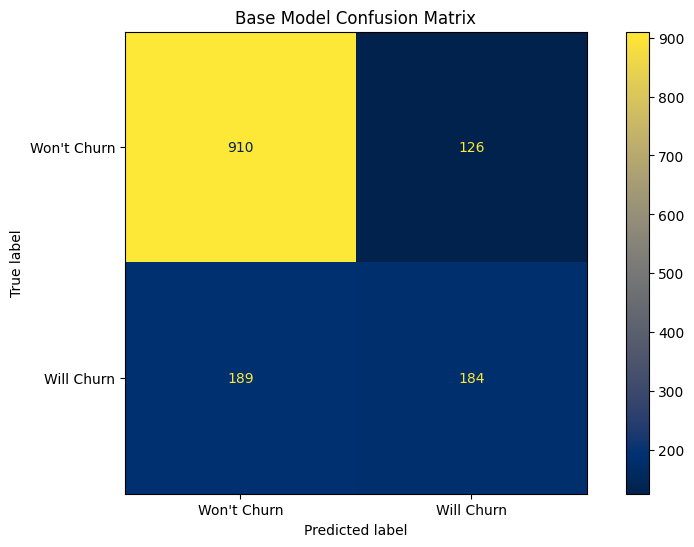

In [42]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,6))

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Won't Churn", "Will Churn"])
# Construct the Confusion Matrix
disp.plot(cmap='cividis', ax=ax)
plt.title('Base Model Confusion Matrix')
plt.savefig('churn_prediction_visuals/base_model_cm')
plt.show()

- The model is better at identifying customers who won’t churn (high true negatives) than those who will.
- False negatives are relatively high, meaning many churners are being missed.

## Hyperparameter Tuning

We will use GridSearch to test and identify optimal hyperparameters for the best model performance. GridSearch will test all combinations of parameters in the parameter grid, recording and comparing performance to select the set of parameters that provides the best model performance. Each combination is tested by training the model and validating based on cross validation folds. 

In [43]:
# Compute the imbalance ratio
ratio = np.sum(y_train == 0) / np.sum(y_train == 1)

# Find Hyperparameters
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.3],
    'reg_alpha': [0, 5],
    'reg_lambda': [1, 5],
    'scale_pos_weight': [1, round(ratio, 2)]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(eval_metric='aucpr', random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 5, 'scale_pos_weight': 1, 'subsample': 0.8}


## Fit the Tuned Model

In [44]:
# Initialize the classifier
model = xgb.XGBClassifier(
    colsample_bytree=0.8, 
    gamma=0.3, 
    learning_rate=0.1, 
    max_depth=3, 
    min_child_weight=1, 
    n_estimators=50, 
    reg_alpha=0, 
    reg_lambda=5, 
    scale_pos_weight=1, 
    subsample=0.8,
    eval_metric='aucpr',
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Predict labels for the test set
y_pred = model.predict(X_test)

## Model Validation

### ROC-AUC

In [45]:
# AUC ROC score
y_pred_prob = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.8614735474655045


ROC-AUC rose around 0.03 which also indicates improved performance.

### Classification Report

In [46]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.69      0.54      0.61       373

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.80      0.81      0.81      1409



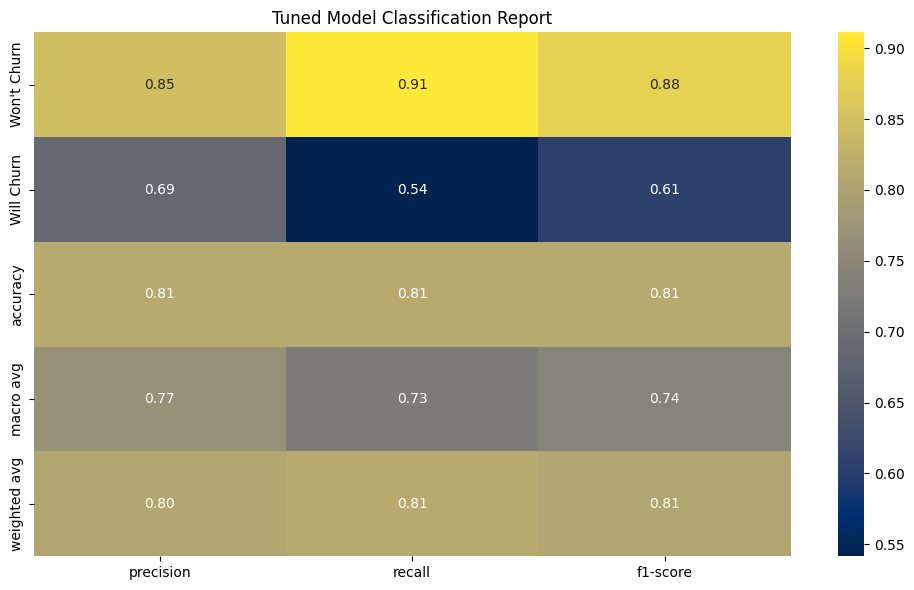

In [47]:
# Save Classification Report as dataframe and transpose
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Drop support column
report_df = report_df.drop(columns=['support'])

# Rename index labels for clarity
report_df.rename(index={'0': "Won't Churn", '1': 'Will Churn'}, inplace=True)

# Construct the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap='cividis', fmt=".2f")
plt.title('Tuned Model Classification Report')
plt.tight_layout()
plt.savefig('churn_prediction_visuals/tuned_model_report.png')
plt.show()

The Tuned Model has slightly increased metrics across the board, indicating better overall performance than the base model. However, it is still biased towards predicting that customers won't churn and recall for predictions of customers who will churn has not risen much.

### Confusion Matrix

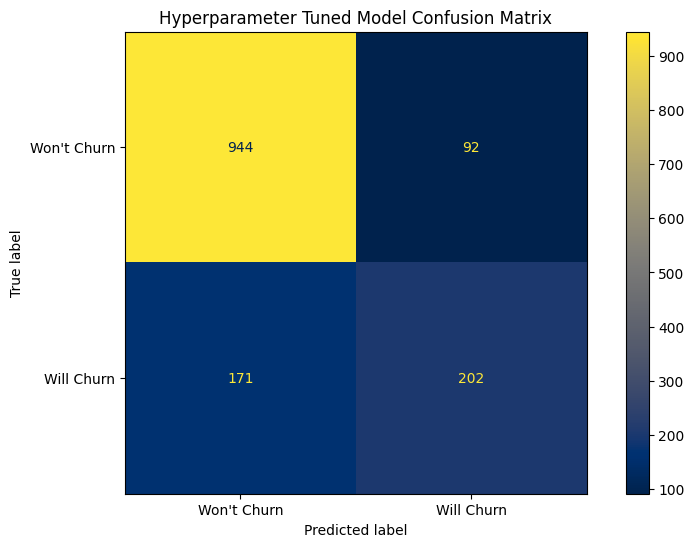

In [48]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,6))

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Won't Churn", "Will Churn"])

# Plot the display
disp.plot(cmap='cividis', ax=ax)
plt.title('Hyperparameter Tuned Model Confusion Matrix')
plt.savefig('churn_prediction_visuals/tuned_model_cm')
plt.show()

The number of True Positives and True Negatives increased while the number of False Positives and False Negatives decreased, indicating higher accuracy and better performance than the previous Base Model.

### Feature Importance

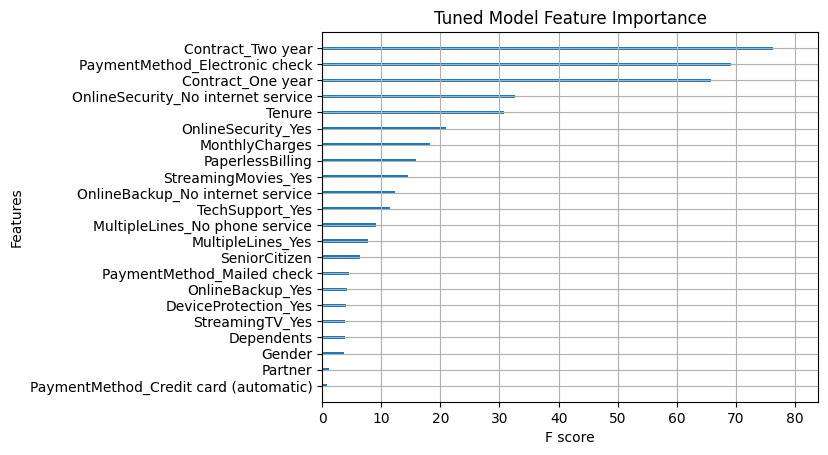

In [49]:
# Plot Feature Importance
xgb.plot_importance(model, importance_type='gain', show_values=False)
plt.title('Tuned Model Feature Importance')

# Save the figure
plt.savefig('churn_prediction_visuals/tuned_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

- The most important feature in the model is the Two-Year Contrac. 
- The next most important features are Payment Method, One-Year Contract, Device Protection, Online Security, Tenure, and Monthly Charges.

# SMOTE Model

## Resampling Data Using SMOTE

Synthetic Minority Oversampling Technique (SMOTE) is a method to balance data by generating some synthetic data for the minorities from existing data. Since the data is imbalanced, a method like SMOTE may improve model performance. 

In [50]:
# Setup SMOTE and random seed
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## Hyperparameter Tuning

In [51]:
# Find Hyperparameters
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.3],
    'reg_alpha': [0, 5],
    'reg_lambda': [1, 5],
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(eval_metric='aucpr', random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}


scale_pos_weight parameter was removed as that helps the model with imbalanced data. Since SMOTE was used, scale_pos_weight should be set to default values, else the model may overcompensate for the minority.

## Fit the Model and Get Predictions

In [52]:
# Set the Hyperparameters for the SMOTE model
smote_model = xgb.XGBClassifier(
    colsample_bytree=0.8, 
    gamma=0.3, 
    learning_rate=0.1, 
    max_depth=5, 
    min_child_weight=1, 
    n_estimators=100, 
    reg_alpha=0, 
    reg_lambda=1, 
    subsample=0.8,
    eval_metric='aucpr',
    random_state=42
)

# Fit the model
smote_model.fit(X_resampled, y_resampled)

# Predict labels for the test set
y_pred_smote = smote_model.predict(X_test)

## Model Validation

### ROC-AUC

In [53]:
# AUC ROC score
y_pred_prob = smote_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.8496019957145963


The ROC AUC score is slightly worse than the Tuned Model but it is an improvement from the Base Model. However, the difference is small (between 1-2%) and the ROC-AUC Score is still high.

### Classification Report

In [54]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_smote))

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1036
           1       0.55      0.77      0.64       373

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.78      1409



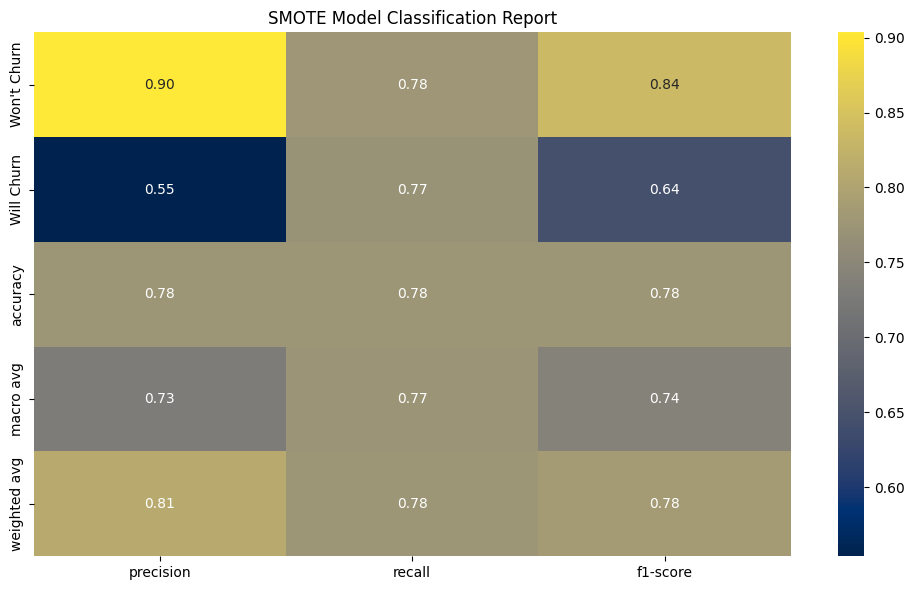

In [55]:
# Save Classification Report as dataframe and transpose
report_dict = classification_report(y_test, y_pred_smote, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Drop support column
report_df = report_df.drop(columns=['support'])

# Rename index labels for clarity
report_df.rename(index={'0': "Won't Churn", '1': 'Will Churn'}, inplace=True)

# Construct the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap='cividis', fmt=".2f")
plt.title('SMOTE Model Classification Report')
plt.tight_layout()
plt.savefig('churn_prediction_visuals/smote_report.png')
plt.show()

The recall for churning customers increased significantly, up around 42% from the Tuned Model (from 0.54 to 0.77). However this came at the tradeoff of lower precision and recall for non-churning customers and lower precision for churning customers. Overall accuracy was also lowered by 0.05.

### Confusion Matrix

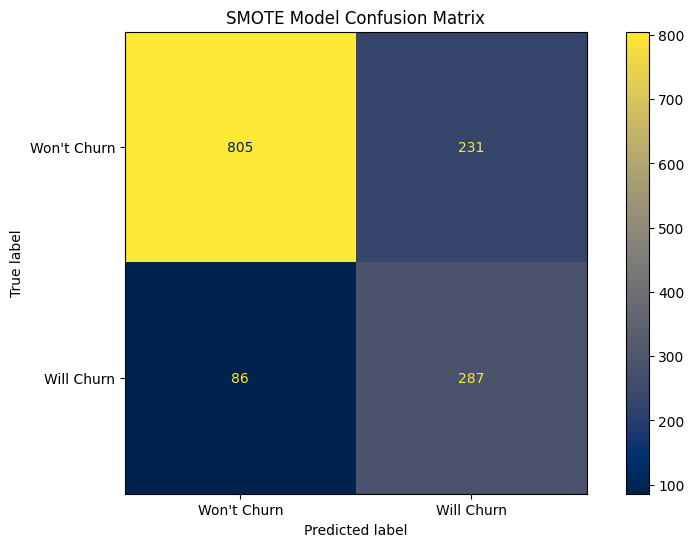

In [56]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_smote)
fig, ax = plt.subplots(figsize=(10,6))

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Won't Churn", "Will Churn"])

# Construct the Confusion Matrix
disp.plot(cmap='cividis', ax=ax)
plt.title('SMOTE Model Confusion Matrix')
plt.savefig('churn_prediction_visuals/smote_cm')
plt.show()

- The SMOTE Model has more correct predictions of when a customer will churn.
- It also makes fewer predictions of "Won't Churn" when a customer acutally churns.
- However, it makes fewer correct predictions of when a customer won't churn and makes many more mistakes, predicting a customer will churn when they actually don't.

### Feature Importance

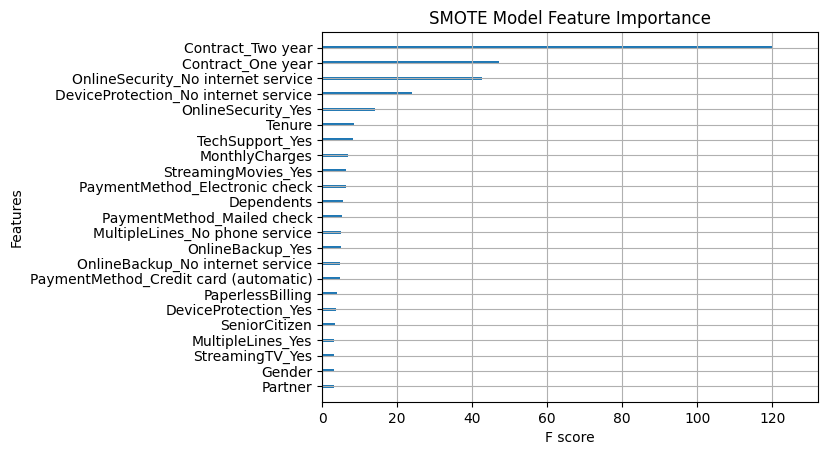

In [57]:
# Plot Feature Importance
xgb.plot_importance(smote_model, importance_type='gain', show_values=False)
plt.title('SMOTE Model Feature Importance')

# Save the figure
plt.savefig('churn_prediction_visuals/smote_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

Contract Type and Online Security are significantly more important to the SMOTE Model than other features.

# Conclusion

For predicting customer churn, the SMOTE model should chosen despite having lower accuracy than the Base Model and Tuned Models. Because telecom data tends to be imbalanced with customer churn being the minority, models should be optimized for the highest recall, which the SMOTE Model has (up to 42% improvement from the Tuned Model).

# Data Source and License

Dataset: Telco Customer Churn

Authors: scottdangelo

Source: [IBM](https://github.com/IBM/telco-customer-churn-on-icp4d)

License: Apache License 2.0

Reference: IBM. (2019). Telco Customer Churn for Watson Studio.